# Imports

In [1]:
import numpy as np
import os

import tensorflow as tf

import cv2

from PIL import Image
from PIL import ImageDraw, ImageFont

from matplotlib import pyplot as plt

import colorsys
from copy import deepcopy

# Loading Model

In [2]:
model_path = '../models/yolo.h5'

In [3]:
darknet = tf.keras.models.load_model(model_path)

In [4]:
print(f'Total Layers: {len(darknet.layers)}')

Total Layers: 252


# Defining Image & Video Processing Functions

In [5]:
def preprocess_input(image_pil, net_h, net_w):
    image = np.asarray(image_pil)
    new_h, new_w, _ = image.shape

    # determine the new size of the image
    if (float(net_w)/new_w) < (float(net_h)/new_h):
        new_h = (new_h * net_w)/new_w
        new_w = net_w
    else:
        new_w = (new_w * net_h)/new_h
        new_h = net_h

    # resize the image to the new size
    #resized = cv2.resize(image[:,:,::-1]/255., (int(new_w), int(new_h)))
    resized = cv2.resize(image/255., (int(new_w), int(new_h)))

    # embed the image into the standard letter box
    new_image = np.ones((net_h, net_w, 3)) * 0.5
    new_image[int((net_h-new_h)//2):int((net_h+new_h)//2), int((net_w-new_w)//2):int((net_w+new_w)//2), :] = resized
    new_image = np.expand_dims(new_image, 0)

    return new_image

In [6]:
anchors = [[[116,90], [156,198], [373,326]], [[30,61], [62,45], [59,119]], [[10,13], [16,30], [33,23]]]

labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", \
              "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", \
              "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", \
              "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", \
              "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", \
              "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", \
              "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", \
              "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", \
              "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", \
              "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]  

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3          

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

def decode_netout(netout_, obj_thresh, anchors_, image_h, image_w, net_h, net_w):
    netout_all = deepcopy(netout_)
    boxes_all = []
    for i in range(len(netout_all)):
      netout = netout_all[i][0]
      anchors = anchors_[i]

      grid_h, grid_w = netout.shape[:2]
      nb_box = 3
      netout = netout.reshape((grid_h, grid_w, nb_box, -1))
      nb_class = netout.shape[-1] - 5

      boxes = []

      netout[..., :2]  = _sigmoid(netout[..., :2])
      netout[..., 4:]  = _sigmoid(netout[..., 4:])
      netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
      netout[..., 5:] *= netout[..., 5:] > obj_thresh

      for i in range(grid_h*grid_w):
          row = i // grid_w
          col = i % grid_w
          
          for b in range(nb_box):
              # 4th element is objectness score
              objectness = netout[row][col][b][4]
              #objectness = netout[..., :4]
              # last elements are class probabilities
              classes = netout[row][col][b][5:]
              
              if((classes <= obj_thresh).all()): continue
              
              # first 4 elements are x, y, w, and h
              x, y, w, h = netout[row][col][b][:4]

              x = (col + x) / grid_w # center position, unit: image width
              y = (row + y) / grid_h # center position, unit: image height
              w = anchors[b][0] * np.exp(w) / net_w # unit: image width
              h = anchors[b][1] * np.exp(h) / net_h # unit: image height  
            
              box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
              #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

              boxes.append(box)

      boxes_all += boxes

    # Correct boxes
    boxes_all = correct_yolo_boxes(boxes_all, image_h, image_w, net_h, net_w)
    
    return boxes_all

def correct_yolo_boxes(boxes_, image_h, image_w, net_h, net_w):
    boxes = deepcopy(boxes_)
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h
        
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
    return boxes
        
def do_nms(boxes_, nms_thresh, obj_thresh):
    boxes = deepcopy(boxes_)
    if len(boxes) > 0:
        num_class = len(boxes[0].classes)
    else:
        return
        
    for c in range(num_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

    new_boxes = []
    for box in boxes:
        label = -1
        
        for i in range(num_class):
            if box.classes[i] > obj_thresh:
                label = i
                # print("{}: {}, ({}, {})".format(labels[i], box.classes[i]*100, box.xmin, box.ymin))
                box.label = label
                box.score = box.classes[i]
                new_boxes.append(box)    

    return new_boxes

def draw_boxes(image_, boxes, labels):
    image = image_.copy()
    image_w, image_h = image.size
    # font = ImageFont.truetype(font='/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf',
    #                 size=np.floor(3e-2 * image_h + 0.5).astype('int32'))

    font = ImageFont.truetype("arial.ttf", 15)

    thickness = (image_w + image_h) // 300

    # Generate colors for drawing bounding boxes.
    hsv_tuples = [(x / len(labels), 1., 1.)
                  for x in range(len(labels))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(
        map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    np.random.seed(10101)  # Fixed seed for consistent colors across runs.
    np.random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    np.random.seed(None)  # Reset seed to default.

    for i, box in reversed(list(enumerate(boxes))):
        c = box.get_label()
        predicted_class = labels[c]
        score = box.get_score()
        top, left, bottom, right = box.ymin, box.xmin, box.ymax, box.xmax

        label = '{} {:.2f}'.format(predicted_class, score)
        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)
        #label_size = draw.textsize(label)

        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image_h, np.floor(bottom + 0.5).astype('int32'))
        right = min(image_w, np.floor(right + 0.5).astype('int32'))
        
        # print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i],
                outline=colors[c])
        draw.rectangle(
            [tuple(text_origin), tuple(text_origin + label_size)],
            fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        #draw.text(text_origin, label, fill=(0, 0, 0))
        del draw
    return image

In [7]:
def predict_frame(image_pil, obj_thresh = 0.4, nms_thresh = 0.45, darknet=darknet, net_h=416, net_w=416, anchors=anchors, labels=labels):
  new_image = preprocess_input(image_pil, net_h, net_w)
  yolo_outputs = darknet.predict(new_image)

  boxes = decode_netout(yolo_outputs, obj_thresh, anchors, 400, 720, net_h, net_w)

  boxes = do_nms(boxes, nms_thresh, obj_thresh) 

  img_detect = draw_boxes(image_pil, boxes, labels)
  return img_detect

In [8]:
def read_image(image_path):
  raw_image = Image.open(image_path).convert('RGB')
  image_pil = raw_image.resize((720,400))
  
  return predict_frame(image_pil)

In [9]:
def read_video(video_path, counter):
    vidcap = cv2.VideoCapture(video_path)
    success,image = vidcap.read()
    count = 0

    
    imgs = []
    frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT)) 

    for i in range(1, frame_count + 1):
        success, image = vidcap.read()
        # cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        imgs.append(image)
        count += 1

    preds = []
    for frame in range(1, frame_count-1, counter):
        # cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        # pil_converted = Image.fromarray(imgs[frame])

        pil_converted = Image.fromarray(cv2.cvtColor(imgs[frame], cv2.COLOR_BGR2RGB))
        image_pil = pil_converted.resize((720,400))

        plt.figure(figsize=(15,7))
        output = predict_frame(image_pil, obj_thresh=0.55)
        plt.title(f'Frame {frame}, {output}')
        plt.imshow(output)

        preds.append(output)
        # output.save(f'out{frame}.jpg')
    return preds

# Testing Model (Images)

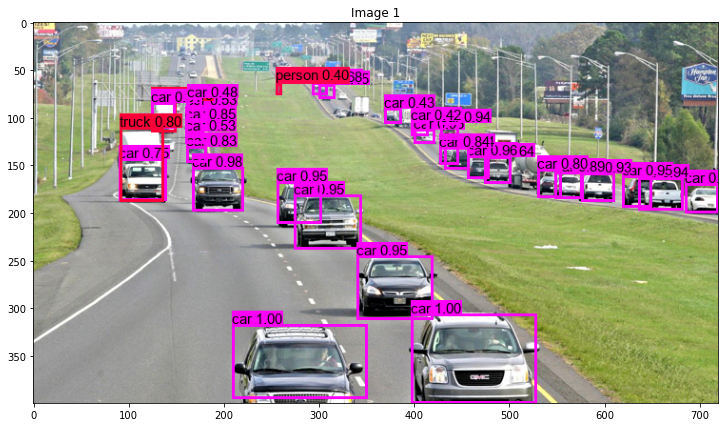

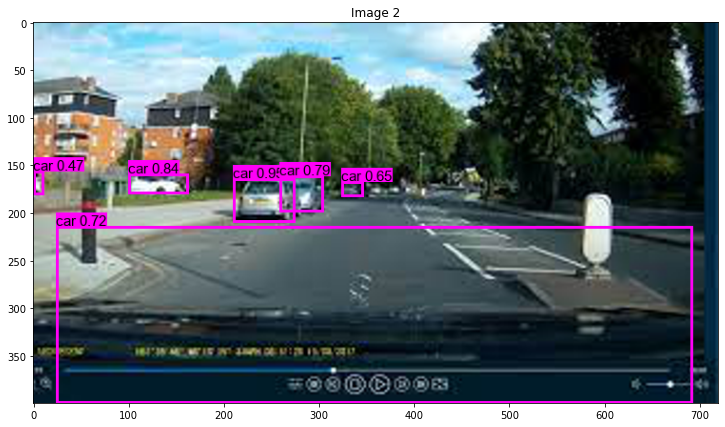

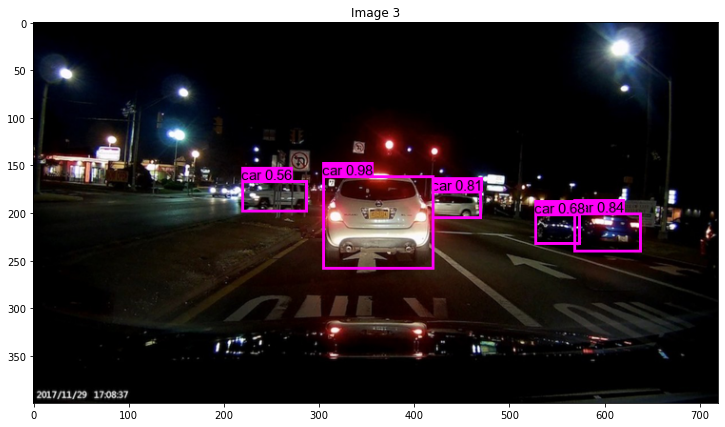

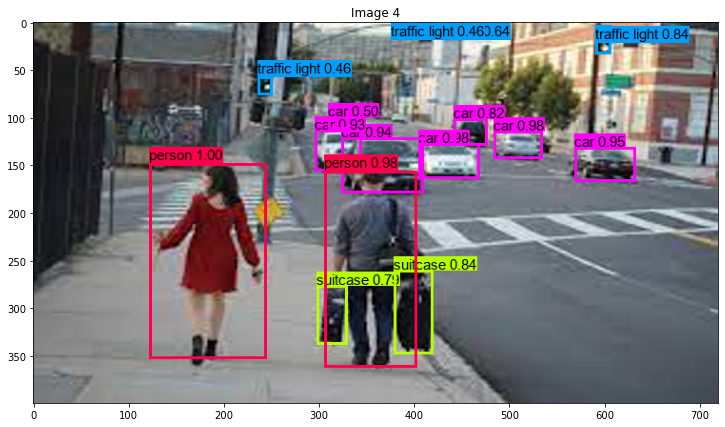

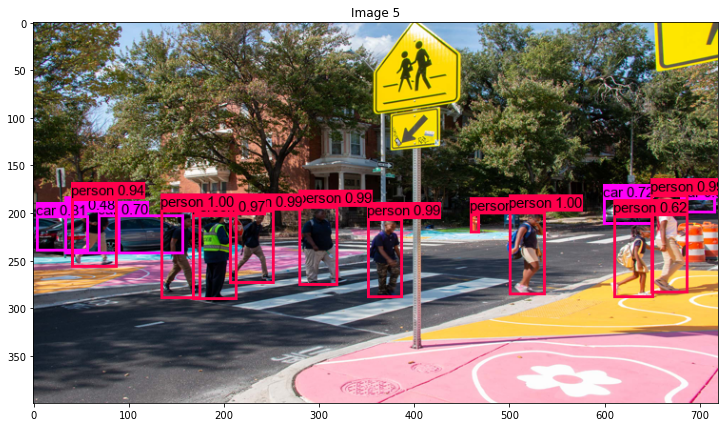

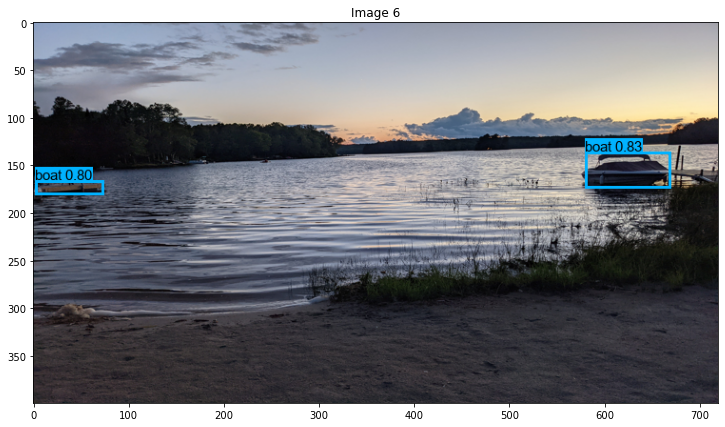

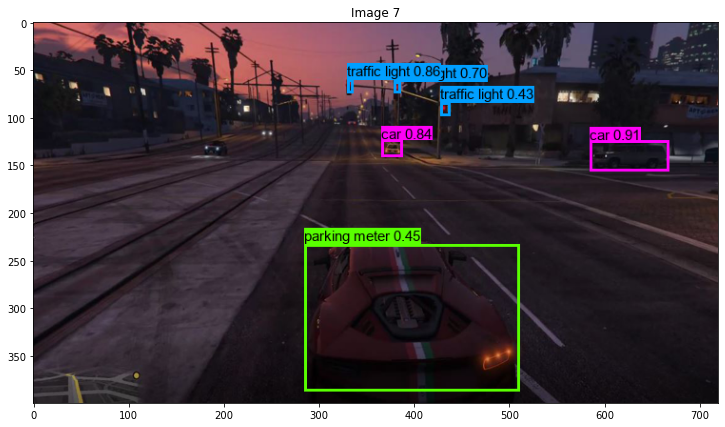

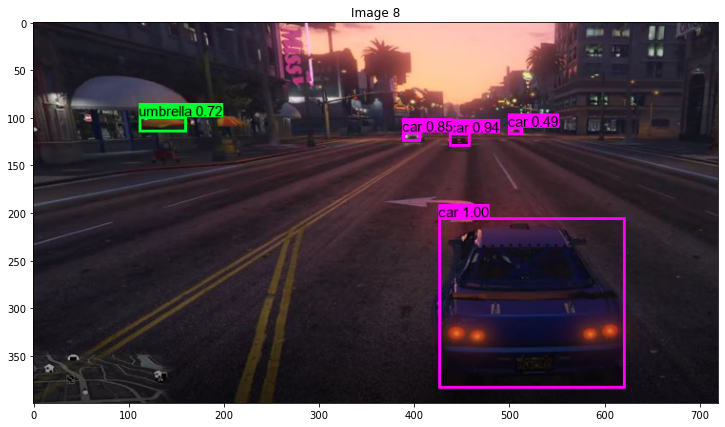

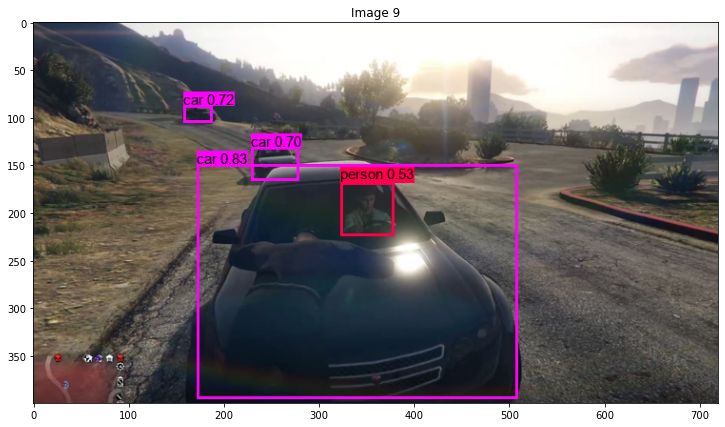

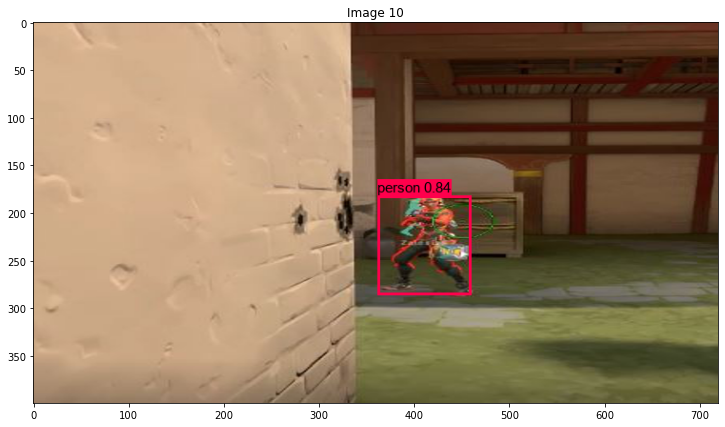

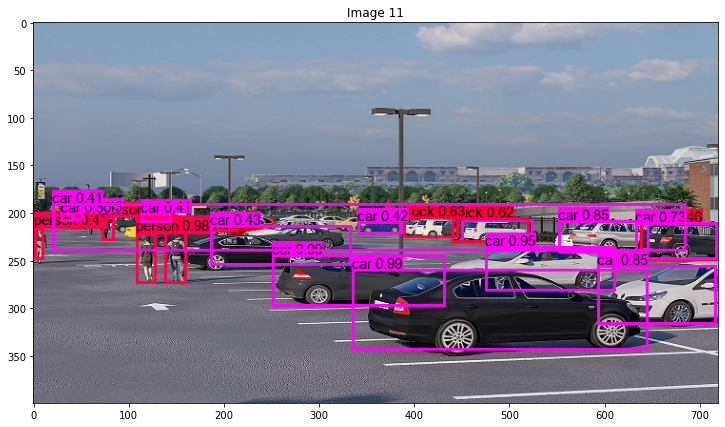

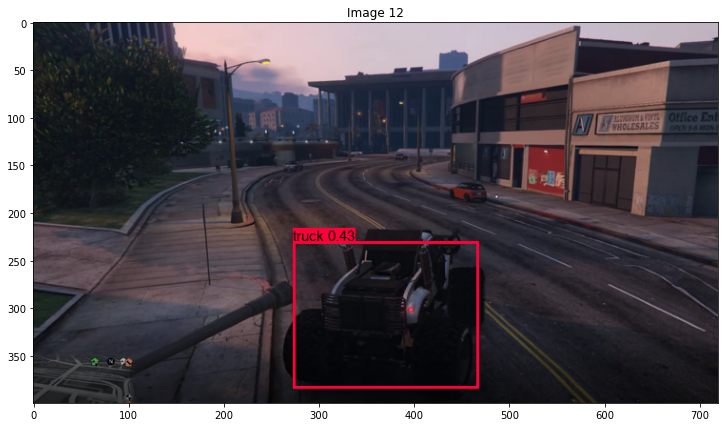

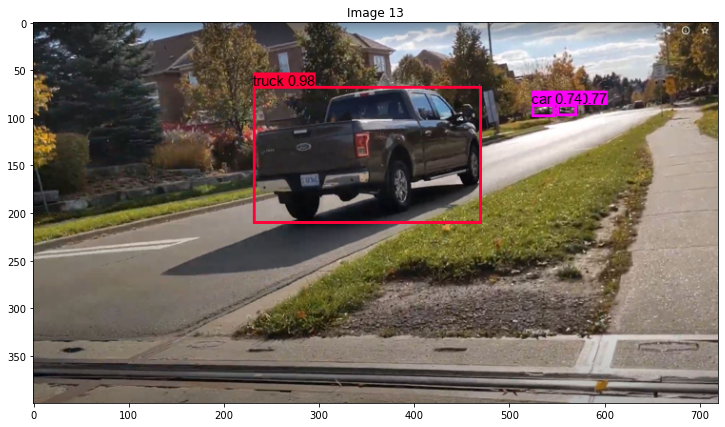

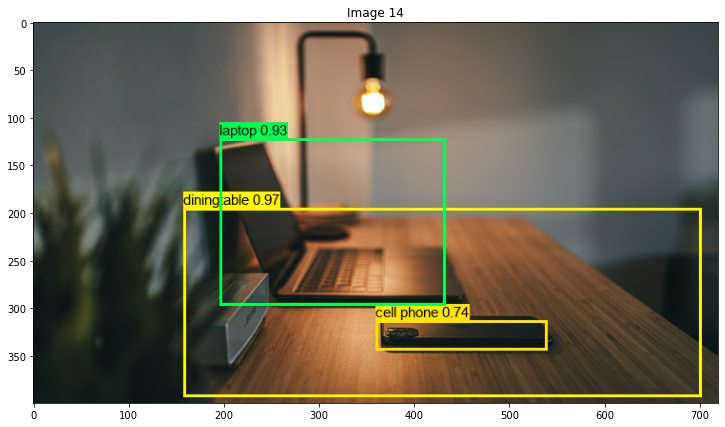

In [10]:
for i in range(1,15):
    plt.figure(figsize=(15,7))
    output = read_image(f'../test-files/image{i}.jpg')
    plt.title(f'Image {i}')
    plt.imshow(output)

# Testing Model (Videos)

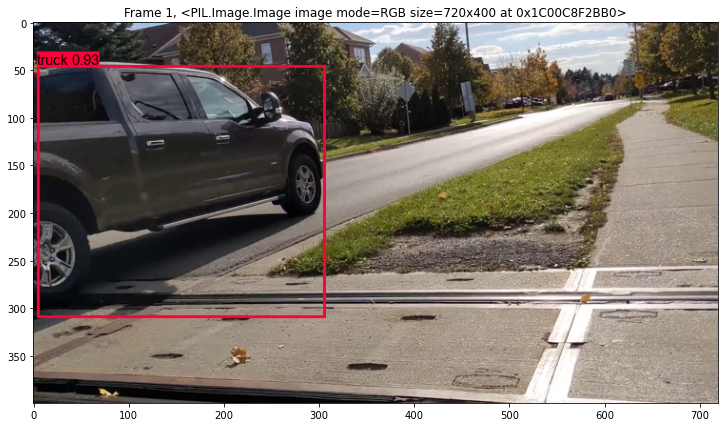

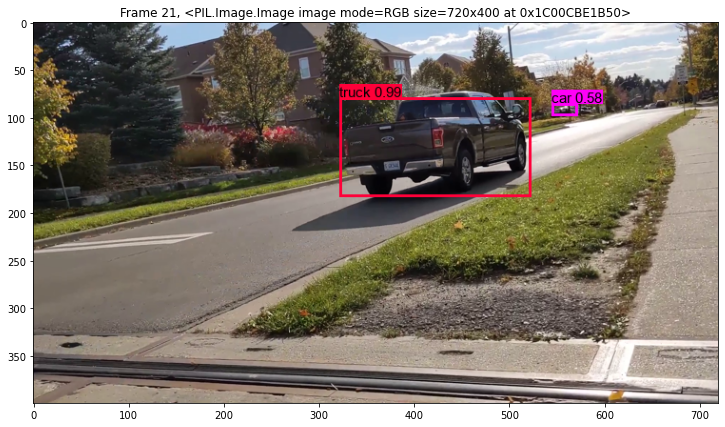

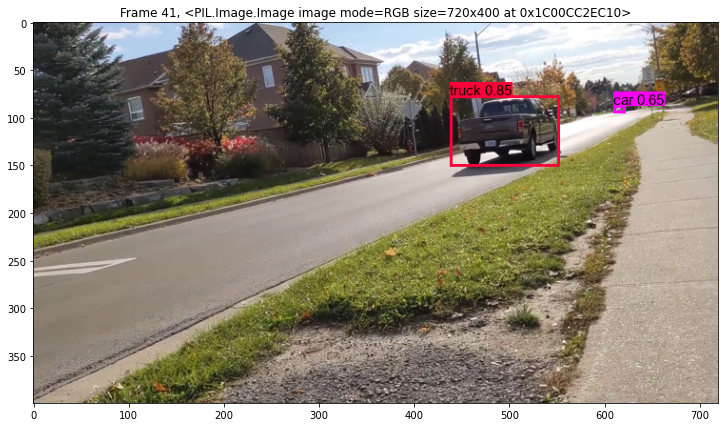

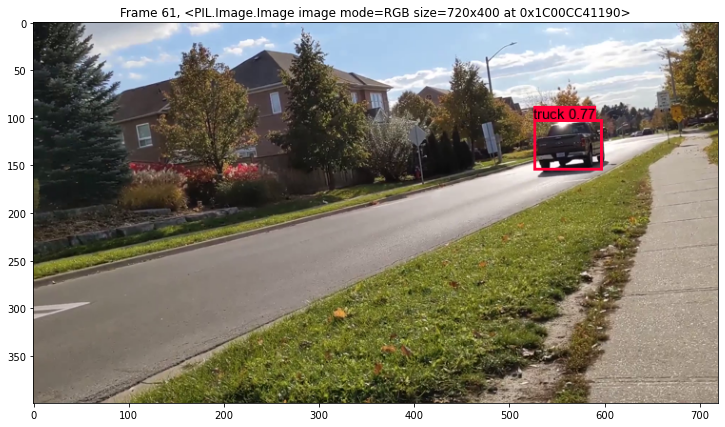

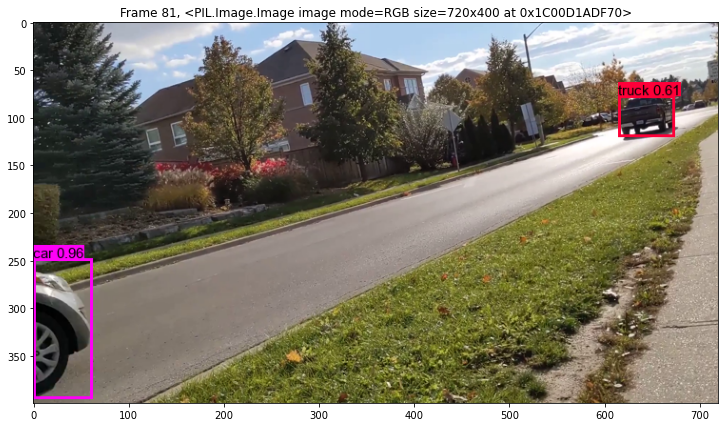

In [11]:
walk_video = read_video('../test-files/video1.mp4', 20)